Libraries needed

In [62]:
import os
import torch
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch.nn.functional as F
import PIL
from torchvision import transforms
from tensorflow.io import gfile

In [134]:
from sklearn.feature_extraction import image

load demo image and read image properties

torch.Size([1, 150, 150])
torch.Size([1, 1, 150, 150])


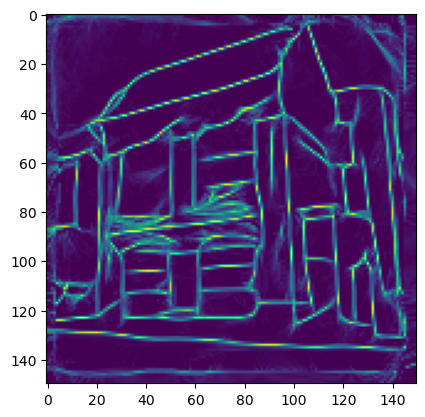

In [151]:
filepath = 'img1.png'

img = PIL.Image.open(filepath).resize((150, 150))

plt.imshow(np.array(img))

img_tensor = transforms.ToTensor()(img)

print(img_tensor.shape)

temp = torch.unsqueeze(img_tensor, 0)
print(temp.shape)

To visualize one slice

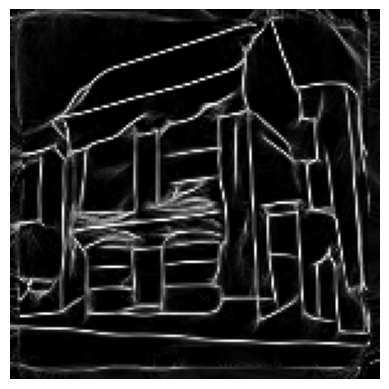

In [86]:
plt.imshow(img_tensor.view(150,150,1), cmap='gray')
plt.axis('off')
plt.show()

In [217]:
#https://stackoverflow.com/questions/68150248/how-to-extract-overlapping-patches-from-a-3d-volume-and-recreate-the-input-shape

def extract_patches_2ds(x, kernel_size, padding=0, stride=1):
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if isinstance(padding, int):
        padding = (padding, padding, padding, padding)
    if isinstance(stride, int):
        stride = (stride, stride)

    channels = x.shape[1]

    x = torch.nn.functional.pad(x, padding)
    # (B, C, H, W)
    x = x.unfold(2, kernel_size[0], stride[0]).unfold(3, kernel_size[1], stride[1])
    # (B, C, h_dim_out, w_dim_out, kernel_size[0], kernel_size[1])
    x = x.contiguous().view(-1, channels, kernel_size[0], kernel_size[1])
    # (B * h_dim_out * w_dim_out, C, kernel_size[0], kernel_size[1])
    return x

def extract_patches_2d(x, kernel_size, padding=0, stride=1, dilation=1):
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if isinstance(padding, int):
        padding = (padding, padding)
    if isinstance(stride, int):
        stride = (stride, stride)
    if isinstance(dilation, int):
        dilation = (dilation, dilation)

    def get_dim_blocks(dim_in, dim_kernel_size, dim_padding = 0, dim_stride = 1, dim_dilation = 1):
        dim_out = (dim_in + 2 * dim_padding - dim_dilation * (dim_kernel_size - 1) - 1) // dim_stride + 1
        return dim_out
        
    channels = x.shape[1]
    h_dim_in = x.shape[2]
    w_dim_in = x.shape[3]
    h_dim_out = get_dim_blocks(h_dim_in, kernel_size[0], padding[0], stride[0], dilation[0])
    w_dim_out = get_dim_blocks(w_dim_in, kernel_size[1], padding[1], stride[1], dilation[1])

    # (B, C, H, W)
    x = torch.nn.functional.unfold(x, kernel_size, padding=padding, stride=stride, dilation=dilation)
    # (B, C * kernel_size[0] * kernel_size[1], h_dim_out * w_dim_out)
    x = x.view(-1, channels, kernel_size[0], kernel_size[1], h_dim_out, w_dim_out)
    # (B, C, kernel_size[0], kernel_size[1], h_dim_out, w_dim_out)
    x = x.permute(0,1,4,5,2,3)
    # (B, C, h_dim_out, w_dim_out, kernel_size[0], kernel_size[1])
    x = x.contiguous().view(-1, channels, kernel_size[0], kernel_size[1])
    # (B * h_dim_out * w_dim_out, C, kernel_size[0], kernel_size[1])
    return x


def combine_patches_2d(x, kernel_size, output_shape, padding=0, stride=1, dilation=1):
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if isinstance(padding, int):
        padding = (padding, padding)
    if isinstance(stride, int):
        stride = (stride, stride)
    if isinstance(dilation, int):
        dilation = (dilation, dilation)

    def get_dim_blocks(dim_in, dim_kernel_size, dim_padding = 0, dim_stride = 1, dim_dilation = 1):
        dim_out = (dim_in + 2 * dim_padding - dim_dilation * (dim_kernel_size - 1) - 1) // dim_stride + 1
        return dim_out

    channels = x.shape[1]
    h_dim_out, w_dim_out = output_shape[2:]
    h_dim_in = get_dim_blocks(h_dim_out, kernel_size[0], padding[0], stride[0], dilation[0])
    w_dim_in = get_dim_blocks(w_dim_out, kernel_size[1], padding[1], stride[1], dilation[1])

    # (B * h_dim_in * w_dim_in, C, kernel_size[0], kernel_size[1])
    x = x.view(-1, channels, h_dim_in, w_dim_in, kernel_size[0], kernel_size[1])
    # (B, C, h_dim_in, w_dim_in, kernel_size[0], kernel_size[1])
    x = x.permute(0,1,4,5,2,3)
    # (B, C, kernel_size[0], kernel_size[1], h_dim_in, w_dim_in)
    x = x.contiguous().view(-1, channels * kernel_size[0] * kernel_size[1], h_dim_in * w_dim_in)
    # (B, C * kernel_size[0] * kernel_size[1], h_dim_in * w_dim_in)
    x = torch.nn.functional.fold(x, (h_dim_out, w_dim_out), kernel_size=(kernel_size[0], kernel_size[1]), padding=padding, stride=stride, dilation=dilation)
    # (B, C, H, W)
    return x


In [219]:
#patches = extract_patches_2d(a, 2, padding=1, stride=2, dilation=1)
patches = extract_patches_2ds(torch.unsqueeze(img_tensor, 0), 15, padding=10, stride=5)
print(patches.shape)

torch.Size([1024, 1, 15, 15])


In [221]:
reconstructed = combine_patches_2d(patches, 15, (1,1,150,150), padding=10, stride=5, dilation=1)

In [223]:
reconstructed = torch.squeeze(reconstructed, 0)

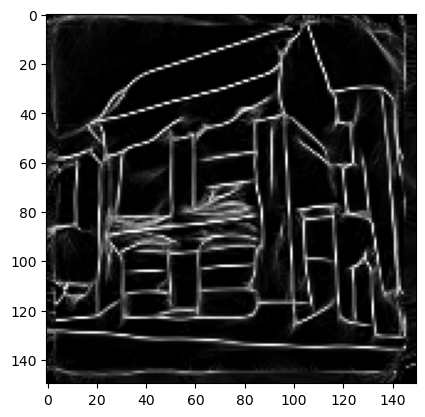

In [225]:
plt.imshow(reconstructed.view(150,150,1), cmap = "gray")

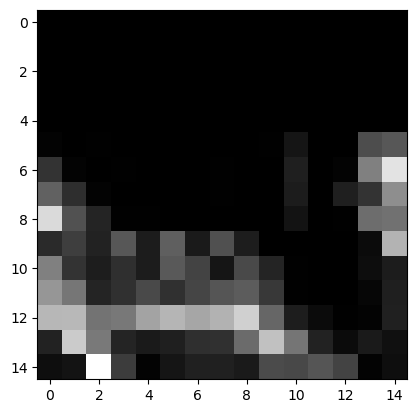

In [215]:
plt.imshow(patches[60,:,:,:].view(15,15,1), cmap = "gray")

MR orientation was changed to coronal, sagittal and axial orientation(maybe not required)

suppose we want to create patches of `32,32,32` so we pad the MR with 0 values(MR air/background) so that all coronal, sagittal and axial dimensions are divisible by 32 or multiples of 32